## Example -- IEA Wind 740-10-MW

**IEA Wind TCP Task 55: The IEA Wind 740-10-MW Reference Offshore Wind Plants**

<https://www.osti.gov/biblio/2333634/>

This notebook uses `optiwindnet` to route the collector system cables for the two wind power plants presented in the report above.

This example requires an additional package:

`pip install pyyaml-include`

In [11]:
import numpy as np
from optiwindnet.api import WindFarmNetwork, MetaHeuristic, MILP

### Additional design parameters

In [12]:
cable_costs = [206, 287, 406]  # [€/m] Costs per distance for each cable type
turbines_per_cable = [3, 5, 7]
cables = [(capacity, cost) for capacity, cost in zip(turbines_per_cable, cable_costs)]

### Load layouts from files

In [13]:
wfn_reg = WindFarmNetwork.from_windIO(filepath='data/IEA37_Borssele_Regular_System.yaml', cables=cables, verbose=True)

In [14]:
wfn_irr = WindFarmNetwork.from_windIO(filepath='data/IEA37_Borssele_Irregular_System.yaml', cables=cables, verbose=True)

<Axes: >

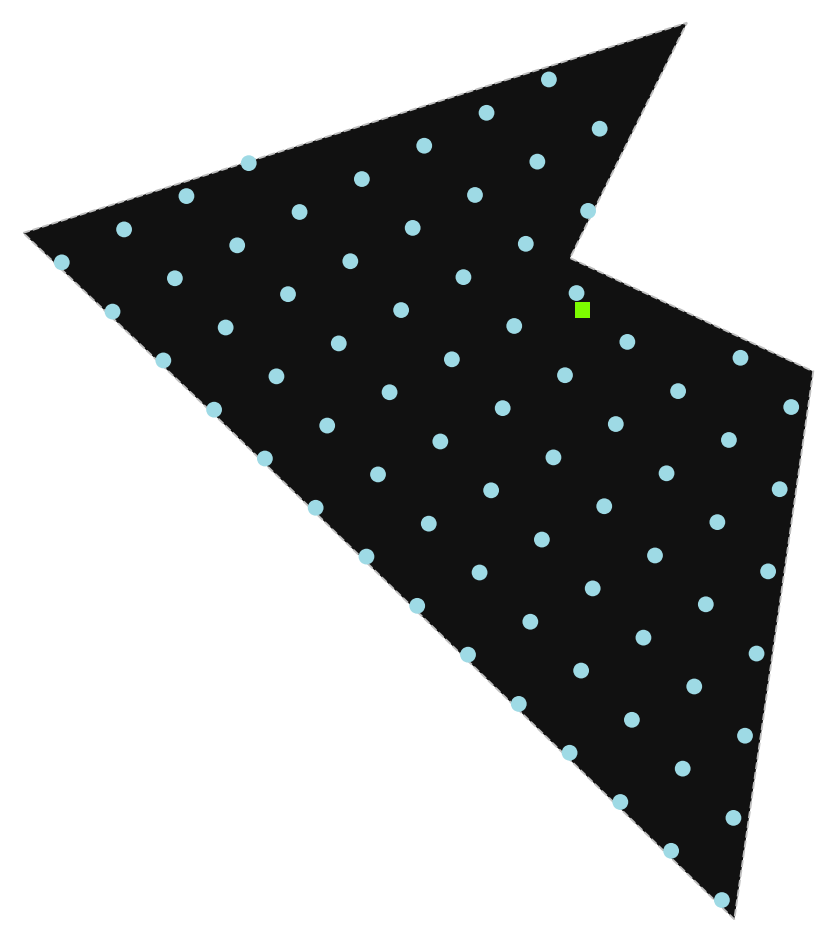

In [15]:
wfn_reg.plot_location()

<Axes: >

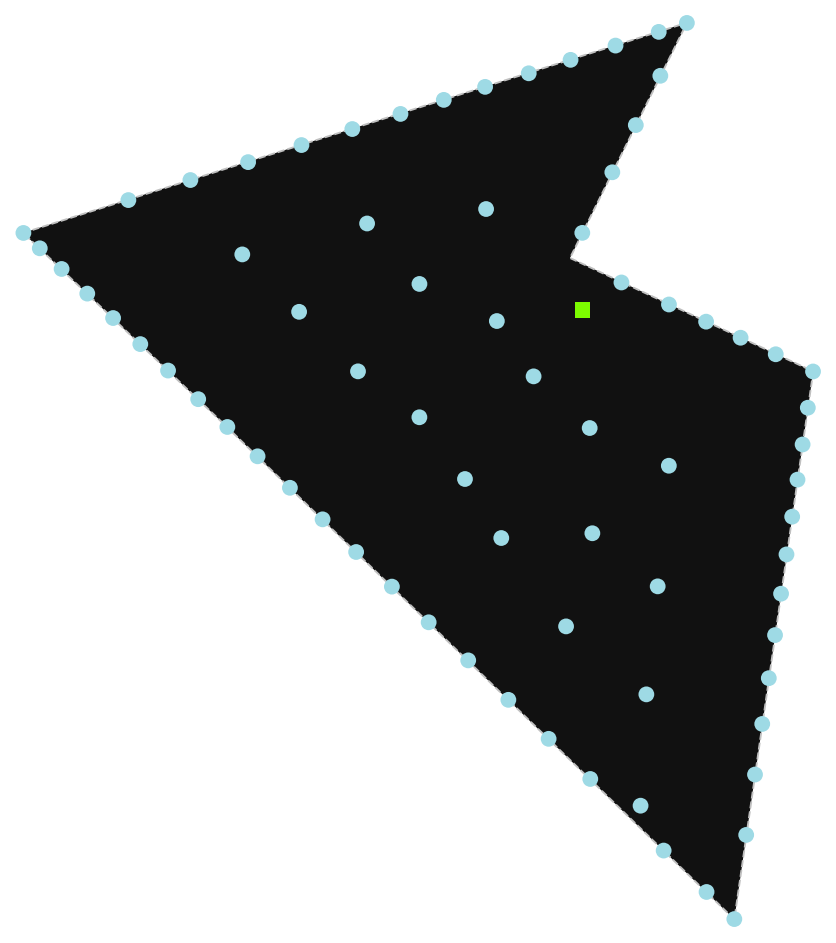

In [16]:
wfn_irr.plot_location()

### Choose solver

In [17]:
warmup_router = MetaHeuristic(time_limit=5)
main_router = MILP(solver='ortools')

### Regular layout

In [18]:
res_reg_warmup = wfn_reg.optimize(router=warmup_router)

Check the total length of the warm-start solution:

In [19]:
wfn_reg.length() # value with hge = 139656.4789599965


139656.4789599965

In [20]:
solver_options=dict(
        max_time_in_seconds = 300,
        relative_gap_limit = 0.005,
        num_workers = 8,


    )

model_options = {"gateXing_constraint": False,
                 "branching": True,
                 "gates_limit": False}

router = MILP(solver='ortools', solver_options=solver_options, model_options=model_options)
res_reg = wfn_reg.optimize(router=router)

S is not None and the model is warmed up with the available S.

Starting CP-SAT solver v9.12.4544
Parameters: max_time_in_seconds: 300 log_search_progress: true relative_gap_limit: 0.005 num_workers: 8

Initial optimization model 'IEA37 Borssele Regular System': (model_fingerprint: 0x9c38920525d6f16)
#Variables: 1'540 (#bools: 770 in floating point objective)
  - 770 Booleans in [0,1]
  - 696 in [0,6]
  - 74 in [0,7]
#kAtMostOne: 615 (#literals: 1'926)
#kLinear1: 1'540 (#enforced: 1'540)
#kLinear3: 2
#kLinearN: 223 (#terms: 3'844)

Starting presolve at 0.00s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 770 terms with magnitude in [440.736, 14559.3] average = 2880.02
[Scaling] Objective coefficient relative error: 6.70633e-10
[Scaling] Objective worst-case absolute error: 7.704e-05
[Scaling] Objective scaling factor: 1.04858e+06
  7.18e-04s  0.00e+00d  [DetectDominanceRelations] 
  1.68e-02s  0.00e+00d  [operations_research::sat::CpModelPresolver

In [21]:
wfn_reg.cost() # originally = 40714260.58298516

40714260.58298516

<Axes: >

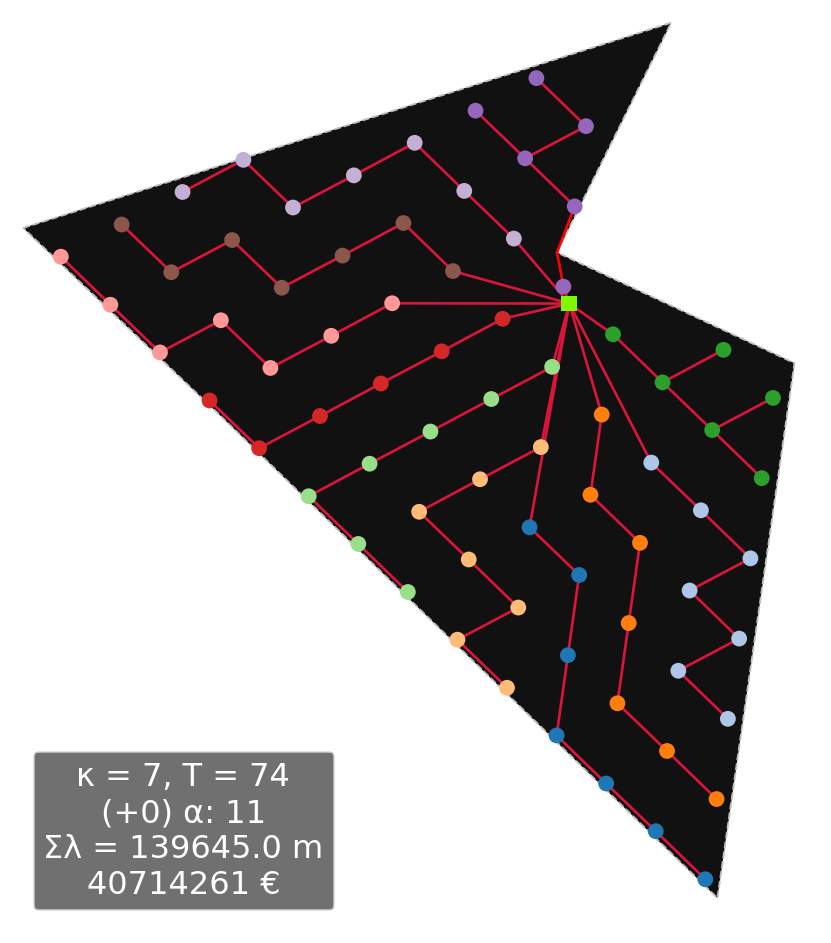

In [22]:
wfn_reg.plot()

### Irregular layout

In [23]:
res_irr_warmup = wfn_irr.optimize(router=warmup_router)

Check the total length of the warm-start solution:

In [24]:
wfn_irr.length() # originally = 136451.2768186806

136472.2480500915

In [25]:
res_irr = wfn_irr.optimize(router=router) # originally gap: 2.8%

S is not None and the model is warmed up with the available S.

Starting CP-SAT solver v9.12.4544
Parameters: max_time_in_seconds: 300 log_search_progress: true relative_gap_limit: 0.005 num_workers: 8

Initial optimization model 'IEA37 Borssele Irregular System': (model_fingerprint: 0x68b2e1d9c4c26564)
#Variables: 1'192 (#bools: 596 in floating point objective)
  - 596 Booleans in [0,1]
  - 522 in [0,6]
  - 74 in [0,7]
#kAtMostOne: 419 (#literals: 1'216)
#kLinear1: 1'192 (#enforced: 1'192)
#kLinear2: 4
#kLinear3: 5
#kLinearN: 216 (#terms: 2'957)

Starting presolve at 0.00s
The solution hint is complete and is feasible.
[Scaling] Floating point objective has 596 terms with magnitude in [539.378, 15073.7] average = 3460.13
[Scaling] Objective coefficient relative error: 4.51281e-10
[Scaling] Objective worst-case absolute error: 7.28067e-05
[Scaling] Objective scaling factor: 1.04858e+06
  5.33e-04s  0.00e+00d  [DetectDominanceRelations] 
  1.06e-02s  0.00e+00d  [operations_research::sat

In [26]:
wfn_irr.cost() # 43091183.191651106

43091183.191651106

<Axes: >

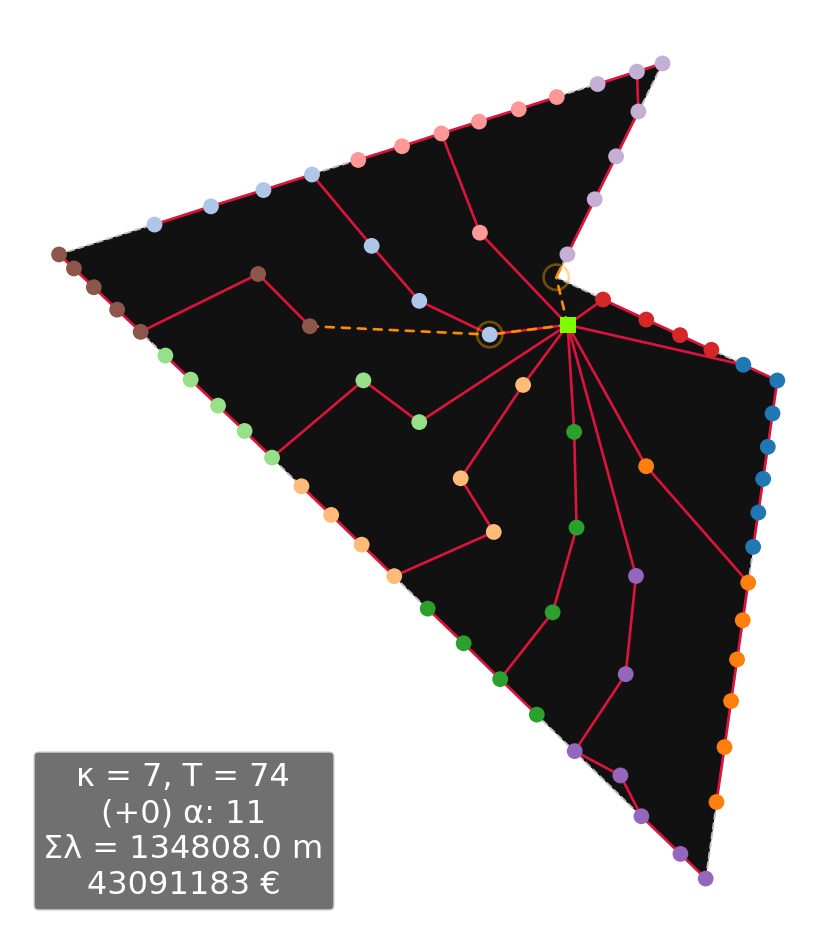

In [27]:
wfn_irr.plot()

### Layouts' edge list

These lists of 3-tuples has all the edges and their cable type (as an index to the `turbines_per_cable` list), i.e. (coordinate_A, coordinate_B, cable_type).

Negative node indices represent substations, the node indices ranging from 0 to 73 represent the WT in the order they were given.

If the layout has contours or detours, indices will go beyond the number of coordinates (WT, SS, borders) provided, and the mapping of these additional indices to indices to the provided coordinates is presented.

In [28]:
wfn_reg.get_network()

[(44,
  45,
  {'length': 1699.0564871355175,
   'load': 5,
   'reverse': True,
   'cable': 1,
   'cost': 487629.21180789353}),
 (44,
  31,
  {'length': 1693.4087878088046,
   'load': 3,
   'reverse': True,
   'cable': 0,
   'cost': 348842.21028861374}),
 (44,
  43,
  {'length': 1699.056848266172,
   'load': 1,
   'reverse': True,
   'cable': 0,
   'cost': 350005.7107428314}),
 (45,
  -1,
  {'length': 1315.6376393023568,
   'load': 6,
   'reverse': False,
   'cable': 2,
   'cost': 534148.8815567568}),
 (18,
  19,
  {'length': 1699.0564871355175,
   'load': 1,
   'reverse': True,
   'cable': 0,
   'cost': 350005.63634991663}),
 (19,
  28,
  {'length': 1693.4087157152337,
   'load': 2,
   'reverse': True,
   'cable': 0,
   'cost': 348842.19543733814}),
 (17,
  26,
  {'length': 1693.4087878088046,
   'load': 4,
   'reverse': True,
   'cable': 1,
   'cost': 486008.32210112695}),
 (17,
  16,
  {'length': 1699.0571834410016,
   'load': 3,
   'reverse': True,
   'cable': 0,
   'cost': 350005.7

In [29]:
network = wfn_reg.get_network_array()
print(network)

[(44, 45, 1699.05648714, 5.,  True, 1,  487629.21180789)
 (44, 31, 1693.40878781, 3.,  True, 0,  348842.21028861)
 (44, 43, 1699.05684827, 1.,  True, 0,  350005.71074283)
 (45, -1, 1315.6376393 , 6., False, 2,  534148.88155676)
 (18, 19, 1699.05648714, 1.,  True, 0,  350005.63634992)
 (19, 28, 1693.40871572, 2.,  True, 0,  348842.19543734)
 (17, 26, 1693.40878781, 4.,  True, 1,  486008.32210113)
 (17, 16, 1699.05718344, 3.,  True, 0,  350005.77978885)
 (26, 25, 1699.05684827, 5., False, 1,  487629.31545239)
 (31, 30, 1699.05718344, 1.,  True, 0,  350005.77978885)
 (31, 42, 1693.40829362, 1., False, 0,  348842.10848476)
 (23, 22, 1699.05648714, 5.,  True, 1,  487629.21180791)
 (23, 33, 1993.85932078, 6.,  True, 2,  809506.88423651)
 (33, -1, 2846.00996322, 7., False, 2, 1155480.04506849)
 (63, 70, 1693.40884935, 1.,  True, 0,  348842.22296592)
 (70, 61, 1693.40871572, 2., False, 0,  348842.19543747)
 (61, 69, 1693.40838202, 3.,  True, 0,  348842.12669691)
 (69, 68, 1699.05723145, 4., Fa

In [30]:
network_cable = np.column_stack((network['src'], network['tgt'], network['cable']))
print(network_cable)


[[44 45  1]
 [44 31  0]
 [44 43  0]
 [45 -1  2]
 [18 19  0]
 [19 28  0]
 [17 26  1]
 [17 16  0]
 [26 25  1]
 [31 30  0]
 [31 42  0]
 [23 22  1]
 [23 33  2]
 [33 -1  2]
 [63 70  0]
 [70 61  0]
 [61 69  0]
 [69 68  1]
 [ 5  4  0]
 [ 5  9  1]
 [ 9 15  1]
 [ 4  1  0]
 [10 11  0]
 [11 16  0]
 [51 62  0]
 [51 60  1]
 [60 59  1]
 [53 62  0]
 [53 64  0]
 [ 3  2  0]
 [ 3  8  0]
 [ 8 14  0]
 [14 22  1]
 [15 24  2]
 [41 52  0]
 [41 54  0]
 [52 39  1]
 [39 50  1]
 [50 49  2]
 [25 34  2]
 [34 -1  2]
 [24 -1  2]
 [28 27  0]
 [ 6  7  0]
 [ 7 12  0]
 [35 36  1]
 [35 46  2]
 [46 -1  2]
 [27 36  1]
 [37 48  1]
 [37 38  0]
 [48 47  1]
 [12 13  0]
 [13 20  1]
 [29 38  0]
 [29 40  0]
 [20 21  1]
 [21 32  2]
 [32 -1  2]
 [ 0  1  0]
 [72 71  0]
 [71 66  0]
 [73 66  0]
 [66 65  1]
 [68 67  1]
 [67 57  2]
 [57 -1  2]
 [65 80  1]
 [56 -1  2]
 [56 80  1]
 [54 55  0]
 [47 -1  2]
 [59 58  2]
 [58 -1  2]
 [49 -1  2]]


Mapping of contour/detour node to the index of its VertexC coordinate :

In [31]:
if wfn_reg.G.graph.get('C') or wfn_reg.G.graph.get('D'):
    R, T, B = (wfn_reg.G.graph[k] for k in 'RTB')
    print(dict(enumerate(
        (n.item() for n in wfn_reg.G.graph['fnT'][T + B:-R]),
        start=T + B
    ))) # originally: {80: 76}

{80: 76}


In [32]:
network = wfn_reg.get_network_array()
network_cable = np.column_stack((network['src'], network['tgt'], network['cable']))
print(network_cable)

[[44 45  1]
 [44 31  0]
 [44 43  0]
 [45 -1  2]
 [18 19  0]
 [19 28  0]
 [17 26  1]
 [17 16  0]
 [26 25  1]
 [31 30  0]
 [31 42  0]
 [23 22  1]
 [23 33  2]
 [33 -1  2]
 [63 70  0]
 [70 61  0]
 [61 69  0]
 [69 68  1]
 [ 5  4  0]
 [ 5  9  1]
 [ 9 15  1]
 [ 4  1  0]
 [10 11  0]
 [11 16  0]
 [51 62  0]
 [51 60  1]
 [60 59  1]
 [53 62  0]
 [53 64  0]
 [ 3  2  0]
 [ 3  8  0]
 [ 8 14  0]
 [14 22  1]
 [15 24  2]
 [41 52  0]
 [41 54  0]
 [52 39  1]
 [39 50  1]
 [50 49  2]
 [25 34  2]
 [34 -1  2]
 [24 -1  2]
 [28 27  0]
 [ 6  7  0]
 [ 7 12  0]
 [35 36  1]
 [35 46  2]
 [46 -1  2]
 [27 36  1]
 [37 48  1]
 [37 38  0]
 [48 47  1]
 [12 13  0]
 [13 20  1]
 [29 38  0]
 [29 40  0]
 [20 21  1]
 [21 32  2]
 [32 -1  2]
 [ 0  1  0]
 [72 71  0]
 [71 66  0]
 [73 66  0]
 [66 65  1]
 [68 67  1]
 [67 57  2]
 [57 -1  2]
 [65 80  1]
 [56 -1  2]
 [56 80  1]
 [54 55  0]
 [47 -1  2]
 [59 58  2]
 [58 -1  2]
 [49 -1  2]]


Mapping of contour/detour node to the index of its VertexC coordinate :

In [33]:
if wfn_irr.G.graph.get('C') or wfn_irr.G.graph.get('D'):
    R, T, B = (wfn_irr.G.graph[k] for k in 'RTB')
    print(dict(enumerate(
        (n.item() for n in wfn_irr.G.graph['fnT'][T + B:-R]),
        start=T + B
    ))) # originally = {80: 28, 81: 76}

{80: 28, 81: 76}
